# Computer Assignment 5c) -- Group 2
* Ali Bemani
* Martin Hellkvist


## Problem setup
In this document, we describe our proposal to decrease the number of signaling exchanges needed in ADMM to reach convergence.

When we computed the number of exchanges for standard ADMM (implemented in 5b) we found that 18 exchanges is due to the dual variables denoted by $\mu_{ij}$, $i,\,j\in\mathcal{E}$.

We propose a way to decrease this number, by introducing some memory in each node to remember the previous value of it's $mu_{ij}$.
For example node 1 keeps memory of $\mu_{15}$, while node 5 keeps memory of $\mu_{51},\dots,\mu_{54},\mu_{56}$.
Node 1 needs to have $\mu_{51}$ to update its corresponding $z$ variable.
Our proposal is that if $\mu_{51}$ is not very different from the previous value, node 5 can choose not to send this value, and node 1 is forced to use the previous value.
Node 5 is still updating the value though.
If the difference goes above some threshold (hyperparameter) the value is communicated.

With this in our implementation, we were able to reduce the number of dual variables communicated from 18 to 3.23 on average.
With $\rho=0.1$ the ADMM converges after 200 iterations.
Using computations for number of exchanges from previous exercise, we see that the number of exchanges is now $200*(28-18+3.23) = 2646$.

With the standard ADMM and the same $\rho$ it converged around 180 iterations, which then converts to $180*28=5040$ exchanges.

## Implementation

In [1]:
##imports from libraries
import pandas as pd
import numpy as np
import time
import math
import sys
import matplotlib.pyplot as plt
import mnist
from PIL import Image

from sklearn.model_selection import train_test_split
from IPython.core.debugger import set_trace


# the "resource" library is not available on windows. 
# if it can be imported, we can use it! For example, while running on google colab
try:
    import resource
    print("Succesfully imported 'resource' package")
except:
    print("Failed on importing 'resource' package, continuing wihtout it!")

Failed on importing 'resource' package, continuing wihtout it!


# Load data

In [2]:
train_data = mnist.train_images()
train_labels = mnist.train_labels()
test_data = mnist.test_images()
test_labels = mnist.test_labels()

(N_train, d0, d1) = train_data.shape
(N_test, _, _) = test_data.shape
decrease_bool = True

## Extract labels 1 and 0, we will only use a binary SVM classifier.

In [3]:
if decrease_bool:
    indexes_0 = (train_labels == 0)
    indexes_1 = (train_labels == 1)

    indexes_0_or_1 = indexes_0 + indexes_1

    test_labels = test_labels[0:5000]
    test_data = test_data[0:5000]

    indexes_0_test = (test_labels == 0)
    indexes_1_test = (test_labels == 1)

    indexes_0_or_1_test = indexes_0_test + indexes_1_test

    train_data = train_data[indexes_0_or_1,:,:]
    train_labels = train_labels[indexes_0_or_1].astype('float64')
    train_labels[train_labels==0] = -1

    test_data = test_data[indexes_0_or_1_test,:,:]
    test_labels = test_labels[indexes_0_or_1_test].astype('float64')
    test_labels[test_labels==0] = -1
    decrease_bool = False

1.0


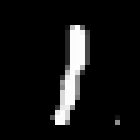

In [4]:
def print_image(idx, data, labels):
    scale= 5
    print(labels[idx])
    return Image.fromarray(np.repeat(np.repeat(data[idx,:,:], scale, axis=1), scale, axis=0))
N = train_data.shape[0]
idx = int(N*np.random.rand())
print_image(idx, train_data, train_labels)

(array([5923.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        6742.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

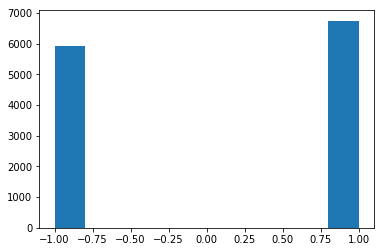

In [5]:
plt.hist(train_labels)

(array([460.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 571.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

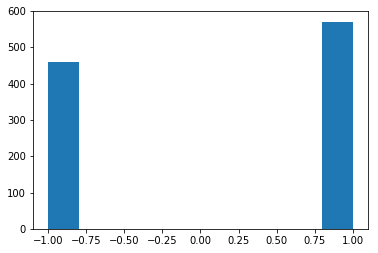

In [6]:
plt.hist(test_labels)

## Split into 10 random disjoint subsets

In [7]:
np.random.seed(0)
N_workers = 10
N_train = 600
print(N_train)
indexes_ = np.random.choice(N_train, size=N_train, replace=False, p=None)
indexes_ = list(indexes_.reshape(10, -1))
X = [np.hstack((train_data[i].reshape(int(N_train/N_workers), -1)/255,np.ones((int(N_train/N_workers),1)))) for i in indexes_]
y = [train_labels[i].reshape(-1,1) for i in indexes_]

600


In [8]:
N_test = test_data.shape[0]
X_test = np.hstack((test_data.reshape(N_test, -1)/255,np.ones((N_test,1))))
y_test = test_labels.reshape(-1, 1)

# Define connectivity
To implement the two-star graph, we use a binary connectivity matrix, just to see which nodes are directly connected:

$$  A = 
\begin{bmatrix} 
1 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & 1 & 0 & 0 & 0 & 0 & 0 \\
1 & 1 & 1 & 1 & 1 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & 1 & 1 & 1 & 1 & 1 \\
0 & 0 & 0 & 0 & 0 & 1 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 1 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 1
\end{bmatrix}  $$

In [9]:
A = np.identity(10, dtype='int8')
A[4,0:6] = 1
A[5,4:10] = 1
A[0:5,4] = 1
A[5:10,5] = 1
print(A)
A = A.astype('bool')


[[1 0 0 0 1 0 0 0 0 0]
 [0 1 0 0 1 0 0 0 0 0]
 [0 0 1 0 1 0 0 0 0 0]
 [0 0 0 1 1 0 0 0 0 0]
 [1 1 1 1 1 1 0 0 0 0]
 [0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 1 1 0 0 0]
 [0 0 0 0 0 1 0 1 0 0]
 [0 0 0 0 0 1 0 0 1 0]
 [0 0 0 0 0 1 0 0 0 1]]


### Compute Grad

In [10]:
def compute_gradient(w, X, Y, lambda_):
    # returns a vector of shape w.shape, with gradients of w
    N = X.shape[0]
    L = hinge_loss(w, X, Y).flatten()
    YX_neg = -Y*X # (N, d)
    YX_neg[L == 0, :] = 0
    g = np.sum(YX_neg, axis=0, keepdims=1)
    g = g.T/N
    
    reg =  2*lambda_ * w
#     set_trace()

    return g + reg

### Compute hingeloss

In [11]:
def hinge_loss(w, X, Y):
#     set_trace()
    # returns the hinge loss for each datapoint in (X,Y) as a vector (N,1)
    (N, d) = X.shape
    assert w.shape == (d,1)
    assert Y.shape == (N,1)
    L = 1. - Y * (X @ w) # (N,1)
#     set_trace()
    L[L < 0] = 0.
    return L

### Cost

In [12]:
def cost(w, X, Y):
    return np.sum(hinge_loss(w,X,Y))

### Predict

In [13]:
def predict(w, X):
    return np.sign(X @ w)

### Accuracy

In [14]:
def accuracy(w, X, Y):
    N = X.shape[0]
    preds = predict(w, X)
    corrects = np.sum(preds == Y)
    return corrects/N

### Average over neighbors

In [15]:
def average_neighbors(W, A, noise_std, p_val):
    # return an average of the weights between the neighbors
    # the return is of shape W.shape
    (d,N_neighs) = W.shape
    for i in range(N_neighs):
        Ai = A[i,:]
        degree_i = np.sum(Ai)
#         set_trace()
        w_bar = np.sum(W[:, Ai], axis=1, keepdims=1) 
        for n in range(degree_i - 1):
            w_bar += np.random.normal(loc=0, scale=noise_std)*(np.random.rand() < p_val)
        assert w_bar.shape == (d, 1)
        W[:,[i]] = w_bar/degree_i
    return W

### Compute z minus mu for a specific node

In [16]:
def compute_z_minus_mu(worker_i, Z, M, A):
    edge_idxs = np.where(A[worker_i,:] == 1)[0]
    # remove self from edge_idxs
    edge_idxs = edge_idxs[np.where(edge_idxs != worker_i)]
    
    summator = 0
    for e in edge_idxs:
        summator += (Z[:, [e], worker_i] - M[:, [e], worker_i])
    
    return summator

### Def solver

In [17]:
def solver(X, Y, X_test, Y_test, A, W, num_iters, alpha, rho, lambda_, epsilon, optimizer = "DSGM",
           mem=False, return_cost=False, verbose=True, seed=-1, p_val=0, R_val=0):
 
    N_workers = len(X)
    dw = W.shape[0]
    assert W.shape[1] == N_workers
    
    noise_std = R_val**0.5
    
    if seed != -1:
        np.random.seed(seed)
    
    cost_ = np.zeros(num_iters+1)
#     cost_index = 9
    if return_cost:
        cost_[0] = accuracy(W[:,[0]], X_test, Y_test)
    
#     set_trace()
    if (optimizer == "DSGM"): # decentralized subgradient method
        for i in range(num_iters):
            W = average_neighbors(W, A, noise_std, p_val)
            for worker_i in range(N_workers):
#                 set_trace()
                w = W[:,[worker_i]]
                g = compute_gradient(w, X[worker_i], Y[worker_i], lambda_)
                W[:,[worker_i]] = w - alpha * g
                
            if return_cost:
                c = 0
                for worker_i in range(N_workers):
                    c += accuracy(W[:,[worker_i]], X_test, Y_test)
                cost_[i+1] = c/N_workers
                
        if (verbose):
            print("DSGM: Number of iterations: ", num_iters, "/", num_iters)
    
    if (optimizer == "ADMM"):
        mu_sends = 0
        
        # set up matrix Z to contain all auxiliary edge variables
        # set up matrix M to contain all dual variables mu

        dz = dw
        Z = np.zeros(shape=(dz,N_workers,N_workers))
        M = np.zeros(shape=(dz,N_workers,N_workers))
        M_old = np.zeros(shape=(dz,N_workers,N_workers))

        # compute degrees = number of neighbors excluding itself
        degs = np.sum(A,axis=1) - 1

        for i in range(num_iters):
            for worker_i in range(N_workers):
                w = W[:,[worker_i]]
                g = compute_gradient(w, X[worker_i], Y[worker_i], lambda_)

                sum_z_minus_mu = compute_z_minus_mu(worker_i, Z, M, A)
                W[:,[worker_i]] = (1/(rho*degs[worker_i])) * (rho*sum_z_minus_mu - g)
            
            # update Z for worker_i
            for worker_i in range(N_workers):
                w = W[:,[worker_i]]
                # loop over neighbors
                edges = np.where(A[worker_i,:] == 1)[0]
                for e in edges:
                    if e != worker_i:
                        mu = M[:, [worker_i], e]
                        mu_old = M_old[:, [worker_i], e]
                        diff = np.mean((mu-mu_old)**2)/(np.linalg.norm(mu)**2 + 1e-15)
#                         set_trace()
                        if  (diff > 0.001) or (i == 0):
                            mu_sends += 1
                            Z[:, [e], worker_i] = (1/2) * (w + W[:,[e]] + (1/rho)*(M[:, [e], worker_i] + mu))
                        else:
                            Z[:, [e], worker_i] = (1/2) * (w + W[:,[e]] + (1/rho)*(M[:, [e], worker_i] + mu_old))
            
            # copy these values of mu and keep in memory
            M_old = np.copy(M)
            for worker_i in range(N_workers):
                w = W[:,[worker_i]]
                edges = np.where(A[worker_i,:] == 1)[0]
                for e in edges:
                    if e != worker_i:
                        M[:, [e], worker_i] = M[:, [e], worker_i] + rho*(w - Z[:, [e], worker_i])
            
            if return_cost:
                c = 0
                for worker_i in range(N_workers):
                    c += accuracy(W[:,[worker_i]], X_test, Y_test)
                cost_[i+1] = c/N_workers

        if (verbose):
            print("ADMM: Number of iterations: ", num_iters, "/", num_iters)
            print("ADMM: final norm: ", np.linalg.norm(g))
            print("Mu sends:", mu_sends, "which is", mu_sends/num_iters, "on average per iteration")
    
    return cost_, W

# Run SVM solver on data

## DSGM

In [18]:
d = X[0].shape[1]
np.random.seed(1)
w = np.random.rand(d,10)

rho = 0
alpha = 5 # for DGSM
num_iters = 500
lambda_ = 0
epsilon = 0
time1 = time.time()

cost_dsgm, w_out_dsgm = solver(X, y, X_test, y_test, A, w, num_iters, alpha, rho, lambda_, epsilon, optimizer = "DSGM", 
                        mem=False, return_cost=True, verbose=True, seed=-1, p_val=0, R_val=0)
time2 = time.time()
print("Runtime DSGM num_iters=", num_iters, ":", time2-time1)

DSGM: Number of iterations:  500 / 500
Runtime DSGM num_iters= 500 : 3.609440565109253


final cost DSGM 0.9970902036857419
final acc: 0.997090203685742
Number of correct: 1028 of 1031


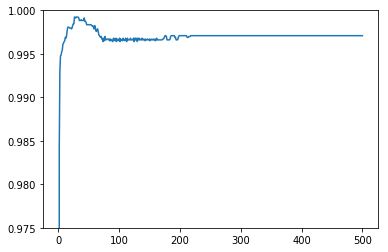

In [19]:
plt.plot(cost_dsgm)
print("final cost DSGM", cost_dsgm[-1])

# plt.yscale('log')
plt.ylim(.975,1)

N_test = X_test.shape[0]
w_dsgm = np.mean(w_out_dsgm, axis=1, keepdims=1)
acc_final = accuracy(w_dsgm, X_test, y_test)
print("final acc:", acc_final)
print("Number of correct:", int(acc_final*N_test), "of", N_test)

## ADMM

In [20]:
d = X[0].shape[1]
np.random.seed(1)
w = np.random.rand(d,10)

rho = .1 # for ADMM
num_iters = 200
lambda_ = 0
epsilon = 0
time1 = time.time()

cost_admm, w_out_admm = solver(X, y, X_test, y_test, A, w, num_iters, alpha, rho, lambda_, epsilon, optimizer = "ADMM", 
                        mem=False, return_cost=True, verbose=True, seed=-1, p_val=0, R_val=0)
time2 = time.time()
print("Runtime ADMM num_iters=", num_iters, ":", time2-time1)

ADMM: Number of iterations:  200 / 200
ADMM: final norm:  0.1647736788572036
Mu sends: 646 which is 3.23 on average per iteration
Runtime ADMM num_iters= 200 : 1.9674475193023682


final acc ADMM 0.9951503394762365
final acc: 0.9951503394762367
Number of correct: 1026.0 of 1031
0.9951503394762367
0.9951503394762367
0.9951503394762367
0.9951503394762367


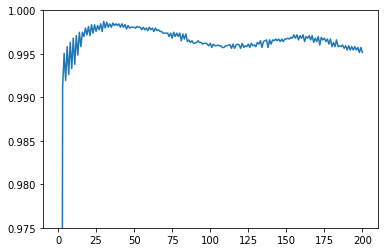

In [21]:
plt.plot(cost_admm)
print("final acc ADMM", cost_admm[-1])
# plt.yscale('log')
plt.ylim(.975, 1)
# plt.xlim(150,250)


N_test = X_test.shape[0]
w_admm = np.mean(w_out_admm, axis=1, keepdims=1)
acc_final = accuracy(w_admm, X_test, y_test)
print("final acc:", acc_final)
print("Number of correct:", acc_final*N_test, "of", N_test)

print(accuracy(w_out_admm[:,[0]], X_test, y_test))
print(accuracy(w_out_admm[:,[1]], X_test, y_test))
print(accuracy(w_out_admm[:,[2]], X_test, y_test))
print(accuracy(w_out_admm[:,[3]], X_test, y_test))

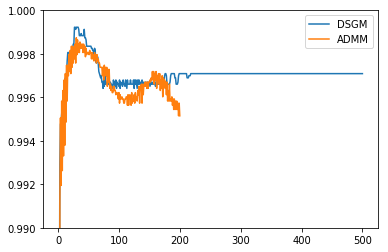

In [22]:
plt.plot(cost_dsgm, label='DSGM')
plt.plot(cost_admm, label='ADMM')

# plt.yscale('log')
plt.ylim(0.990,1)
# plt.xlim(400,500)
plt.legend()

In [23]:
print(np.mean((w_out_admm[:,[0]]-w_out_admm[:,[1]])**2/np.linalg.norm(w_out_admm[:,0])**2))
print(np.mean((w_out_admm[:,[0]]-w_out_admm[:,[2]])**2/np.linalg.norm(w_out_admm[:,0])**2))
print(np.mean((w_out_admm[:,[0]]-w_out_admm[:,[3]])**2/np.linalg.norm(w_out_admm[:,0])**2))
print(np.mean((w_out_admm[:,[0]]-w_out_admm[:,[4]])**2/np.linalg.norm(w_out_admm[:,0])**2))
print(np.mean((w_out_admm[:,[0]]-w_out_admm[:,[5]])**2/np.linalg.norm(w_out_admm[:,0])**2))
print(np.mean((w_out_admm[:,[0]]-w_out_admm[:,[6]])**2/np.linalg.norm(w_out_admm[:,0])**2))
print(np.mean((w_out_admm[:,[0]]-w_out_admm[:,[7]])**2/np.linalg.norm(w_out_admm[:,0])**2))
print(np.mean((w_out_admm[:,[0]]-w_out_admm[:,[8]])**2/np.linalg.norm(w_out_admm[:,0])**2))
print(np.mean((w_out_admm[:,[0]]-w_out_admm[:,[9]])**2/np.linalg.norm(w_out_admm[:,0])**2))

2.2372037110228408e-20
1.0210113857232e-34
1.4685374155677705e-08
4.150976275265287e-07
2.925027534544881e-07
3.549655890330169e-07
2.757401487405506e-06
3.5496558903406094e-07
7.855309820409183e-06


In [24]:
print(np.mean((w_out_dsgm[:,[0]]-w_out_dsgm[:,[1]])**2/np.linalg.norm(w_out_dsgm[:,0])**2))
print(np.mean((w_out_dsgm[:,[0]]-w_out_dsgm[:,[2]])**2/np.linalg.norm(w_out_dsgm[:,0])**2))
print(np.mean((w_out_dsgm[:,[0]]-w_out_dsgm[:,[3]])**2/np.linalg.norm(w_out_dsgm[:,0])**2))
print(np.mean((w_out_dsgm[:,[0]]-w_out_dsgm[:,[4]])**2/np.linalg.norm(w_out_dsgm[:,0])**2))
print(np.mean((w_out_dsgm[:,[0]]-w_out_dsgm[:,[5]])**2/np.linalg.norm(w_out_dsgm[:,0])**2))
print(np.mean((w_out_dsgm[:,[0]]-w_out_dsgm[:,[6]])**2/np.linalg.norm(w_out_dsgm[:,0])**2))
print(np.mean((w_out_dsgm[:,[0]]-w_out_dsgm[:,[7]])**2/np.linalg.norm(w_out_dsgm[:,0])**2))
print(np.mean((w_out_dsgm[:,[0]]-w_out_dsgm[:,[8]])**2/np.linalg.norm(w_out_dsgm[:,0])**2))
print(np.mean((w_out_dsgm[:,[0]]-w_out_dsgm[:,[9]])**2/np.linalg.norm(w_out_dsgm[:,0])**2))

0.0
0.0
0.0
3.654991047185849e-35
2.2122190779410073e-33
2.8066255039841115e-33
2.8066255039841115e-33
2.8066255039841115e-33
2.8066255039841115e-33
